In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from IPython.display import clear_output as clr
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans as KM
import matplotlib as mpl
mpl.rc('image', cmap='gray')

In [2]:
### Importing data
mat = scipy.io.loadmat('mnist_small.mat')
X = mat["X"]
y = mat["Y"]
print("Input shape", X.shape, ", Label shape",y.shape)

Input shape (10000, 784) , Label shape (10000, 1)


## Defining the GMM Class

In [440]:
## Defining the Class of GMM Model
class mPPCA:
    '''
    ||========================================================= Model GMM ==========================================================||
    ||___________________________________________________Developed by Abhishek Kumar________________________________________________||
    ||______________________________________________________________________________________________________________________________||
    
    This is Spherical GMM Model with both batch and stepwise EM algorithm implemented as fit and partial_fit for function respectively.
    '''
    def __init__(self, n_components = 10, max_iter = 200, K = 10):
        
        self.n_components = n_components
        self.means = None
        self.sigmas = None
        self.pis = None
        self.Ws = None
        self.K = K
        self.Ms = None
        self.max_iter = max_iter
        self.idls = [] # Incomplete data log likelihoods
        self.nums = []
    
    def InitVars(self, D):
        self.pis = np.ones((self.n_components,1))/self.n_components
        self.means = np.random.rand(self.n_components, D)
        self.sigmas = np.ones((self.n_components,1))
        self.Ws = np.random.rand(self.n_components, D, self.K)*0.001
        self.Ms_inv = np.zeros((self.n_components, self.K, self.K))
        
        for i in range(self.n_components):
            self.Ms_inv[i,:] = np.linalg.inv(np.dot(self.Ws[i,:].T, self.Ws[i,:]) + self.sigmas[i]*np.eye(self.K))
        
    def E_step(self, X):
        '''
        X : N x D
        '''
        N, D = X.shape
        
        gamma = np.zeros((X.shape[0], self.n_components))
        
        
        for j in range(self.n_components):
            self.Ms_inv[j,:] = np.linalg.inv(np.dot(self.Ws[j,:].T, self.Ws[j,:]) + self.sigmas[j]*np.eye(self.K))
            
            Sigma_m = np.dot(self.Ws[j,:,:],self.Ws[j,:,:].T) + (self.sigmas[j]+1)*np.eye(D) #DxD
#             print(np.linalg.det(Sigma_m))
            Sigma_m_inv = (np.eye(D) - np.dot(np.dot(self.Ws[j,:,:],self.Ms_inv[j,:,:]), self.Ws[j,:,:].T))/self.sigmas[j] # DxD 
            
            delta = X-self.means[j,:] # NxD
            expo = -0.5*np.diag(np.dot(np.dot(delta,Sigma_m_inv), delta.T))
            gamma[:,j] = expo+np.log(self.pis[j])-0.5*np.log(np.linalg.det(Sigma_m)+0.001)
        
        gamma = np.exp((gamma-gamma.max(axis = 1).reshape(-1,1)))
        gamma = gamma/np.sum(gamma, axis = 1).reshape(-1,1)
        
        return gamma
    
    def M_step(self, X, gammas):
        '''
        X : NxD
        gammas : NxK
        '''
        N, D = X.shape
        K = gammas.shape[1]
        Nms = np.sum(gammas, axis = 0).reshape(K,1)+0.0001 # Kx1
        
        #pi
        self.pis = Nms/N
        # mu
        numerator = np.dot(gammas.T, X) # KxD
        self.means = numerator/Nms
        # sigmas, Ws
        prod = np.zeros((N,K))
        for j in range(K):
            
            R = np.diag(gammas[:,j]) # N x N
            delta = X - self.means[j,:] # N x D
            Sigma_m = (np.dot(np.dot(delta.T,R), delta))/Nms[j] # DxD

#             print(Sigma_m.shape, R.shape)
            interm = np.linalg.inv(self.sigmas[j]*np.eye(self.K) + np.dot(self.Ms_inv[j,:,:],np.dot(np.dot(self.Ws[j,:,:].T, Sigma_m), self.Ws[j,:,:])))
            Wm = np.dot(np.dot(Sigma_m, self.Ws[j,:,:]), interm)
            
            sigma_m = np.trace(Sigma_m - np.dot(Sigma_m, np.dot(self.Ws[j,:,:], np.dot(self.Ms_inv[j,:,:], Wm.T))))/D
            
            self.Ws[j,:,:] = Wm
            self.sigmas[j] = sigma_m
            
        
        
    def get_idl(self, X):
        N, D = X.shape
        X_max = X.max()
        likhd = 0
        gamma = np.zeros((N, self.n_components))
        for j in range(self.n_components):    
           
            Sigma_m = np.dot(self.Ws[j,:,:],self.Ws[j,:,:].T) + self.sigmas[j]*np.eye(D)
            Sigma_m_inv = (np.eye(D) - np.dot(np.dot(self.Ws[j,:,:],self.Ms_inv[j,:,:]), self.Ws[j,:,:].T))/self.sigmas[j] # DxD 
            delta = X-self.means[j,:] # NxD
            expo = -0.5*np.diag(np.dot(np.dot(delta,Sigma_m_inv), delta.T))
            gamma[:,j] = expo+np.log(self.pis[j])-(D/2)*np.log(np.linalg.det(Sigma_m)+0.001)
            
        gammas = self.E_step(X)
        mul = np.sum(gammas*gamma)
        
        return mul/N
    
    def fit(self, X):
        '''
        This is Batch EM version
        '''
        N, D = X.shape
        self.InitVars(D)
        print("Computing IDL init")
        old_idl = self.get_idl(X)
        new_idl = old_idl + 100
        for i in range(self.max_iter):
            print("Computing E step epoch , ", i)
            gammas = self.E_step(X)
            print("Computing M step")
            self.M_step(X, gammas)
            print("Computing IDL init")
            new_idl = self.get_idl(X)
            print(new_idl)
            clr(wait = True)
            self.idls.append(new_idl)
            self.nums.append(i*N)
            diff = abs(new_idl - old_idl)
            if(diff < 0.1):
                break
            old_idl = new_idl+0.000001
            
        return self.nums, self.idls 
    
    def partial_fit(self, X, batch_size = 100, kr = 0.55, init_me = True, km_init = False, Full_init = False):
        '''
        This is the stepwise EM version
        '''
        arrs = []
        N, D = X.shape
        if(init_me):
            self.lr = 1
            print("Initializing Variables")
            self.InitVars(D)
            if(km_init):
                print("Initializing means using KMeans")
                kmmodel = KM(n_clusters = self.n_components)
                kmmodel.fit(X)
                self.means = kmmodel.cluster_centers_
            if(Full_init):
                print("Initializing with one step of Batch EM")
                print("Doing E_step_all")
                gammas = self.E_step(X)
                print("Doing M_step_all")
                self.M_step(X, gammas)
                
        else:
            assert(self.means.shape[1] == D)

        old_idl = -999
        new_idl = old_idl + 100
        old_idl_mini = 0
        new_idl_mini = old_idl_mini + 100
        diff = 1000    
        np.random.shuffle(X)
        old_lrate = 0
        n_batches = (N//batch_size)
        
        X_val = X[:batch_size]
        
        
        
        for i in range(self.max_iter*n_batches):
            l_rate = (((i//n_batches)+2)**(-kr))*self.lr
            ul = i%batch_size
            ll = min(ul+batch_size, X.shape[0])
            mini_X = X[ul:ll,:]
            if(mini_X.shape[0] == 0):
                continue 

            pis = self.pis.copy()
            mus = self.means.copy()
            sis = self.sigmas.copy()
            wus = self.Ws.copy()
            print("Doing E_step")
            gammas = self.E_step(mini_X)
            print("Doing M_step") 
            self.M_step(mini_X, gammas)
            print("updating with learning rate")
            self.pis = pis*(1-l_rate) + l_rate*(self.pis)
            self.means = mus*(1-l_rate) + l_rate*(self.means)
            self.sigmas = sis*(1-l_rate) + l_rate*(self.sigmas)
            self.Ws = wus*(1-l_rate) + l_rate*(self.Ws)
              
            new_idl = self.get_idl(mini_X)            
            clr(wait = True)
            print(new_idl)
            
            if(i%n_batches==0):
                new_idl = self.get_idl(X_val)
                self.idls.append(new_idl)
                self.nums.append(i*batch_size)
                diff = abs(new_idl - old_idl)
                if(diff < 0.01):
                    break
                old_idl = new_idl+0.000001
                np.random.shuffle(X)
                
                arrs.append(diff)
                
                check_list = np.array(arrs[-3:])
                check_list_old = np.array(arrs[-6:])
                norm_check = (check_list - check_list.mean())
                norm_check_old = (check_list_old - check_list_old.mean())
#                 print(norm_check, norm_check_old)
                print(new_idl, diff)
                clr(wait = True)
                print(abs(norm_check.mean() - norm_check_old.mean()))
                if(len(arrs) > 10):
                    if(abs(norm_check.mean() - norm_check_old.mean()) < 10e-17):
                        break
                
            
        self.lr = l_rate
            
        return self.nums, self.idls 

In [441]:
meanX = X.mean()
stdX = X.std()
min_X = X.min()
max_X = X.max()

In [442]:
# Xd = (X - meanX)/stdX
Xd = (X - min_X)/(max_X - min_X)-0.5

In [451]:
##  Batch EM 
nC = 10
K = 20
# model = mPPCA(n_components=nC, K = K, max_iter = 3)
# his_batch = model.partial_fit(Xd, batch_size = 500, kr = 1.0, init_me = True, km_init=False)
his_batch = model.partial_fit(Xd, batch_size = 1000, kr = 0.55, init_me = False)

2314.723774481589


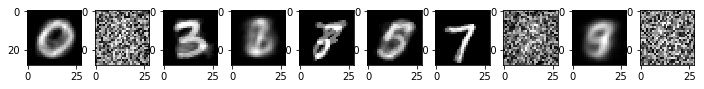

In [449]:
fig = plt.figure(figsize = [12,nC//10])
for i in range(nC):
    ax1=fig.add_subplot(1,nC//1, i+1)
    ax1.imshow(model.means[i].reshape(28,28)*(max_X - min_X) + min_X)
plt.savefig("means_mppca")

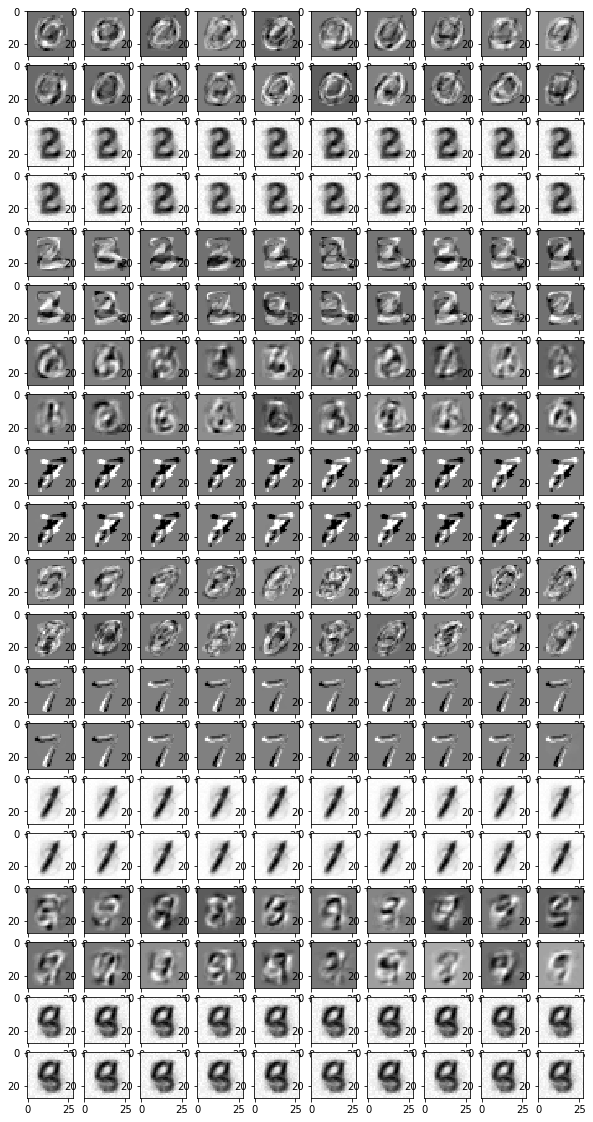

In [450]:
fig = plt.figure(figsize = [K//2,nC*2])
for i in range(nC*K):
    ax1=fig.add_subplot(K,nC, i+1)
    ax1.imshow(model.Ws[i//K,:,i%K].reshape(28,28)*(max_X - min_X) + min_X)
plt.savefig("vars_mppca")